# Import data and libraries

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
caminho_arquivo = '../data/Metro_Interstate_Traffic_Volume.csv'
df = pd.read_csv(caminho_arquivo)

# Basic informations about the dataset

## Head (First Five Rows)

In [36]:
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


## Tail (Last Five Rows)

In [37]:
df.tail()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
48199,NaN,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
48200,NaN,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
48201,NaN,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
48202,NaN,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450
48203,NaN,282.12,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 23:00:00,954


Please note that observations are made on an hourly basis, capturing real-time details such as temperature, precipitation, and weather conditions, with the primary metric being traffic volume.

## Shape (number of rows and columns)

In [38]:
print("\nDataset dimensions (rows, columns):")
df.shape


Dataset dimensions (rows, columns):


(48204, 9)

## Technical Informations

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              61 non-null     object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


Note that the 'holiday' column only contains 61 non-null values because only a minority of days are holidays.  

## Analysis of Temporal Gaps

In [40]:
# --- Prepare data of date time ---

# Convert the column 'date_time' to the datetime format of pandas
# Essential for any time series analysis
df['date_time'] = pd.to_datetime(df['date_time'])

# Set the 'date_time' column as the index of the DataFrame to make it easier to work with time series data
df = df.set_index('date_time')

# Sort the index to ensure the data is in chronological order
df = df.sort_index()

# Show the start and end of the data to confirm the period
print(f"Start date: {df.index.min()}")
print(f"End date: {df.index.max()}")
print(f"Total records: {len(df)}")


Start date: 2012-10-02 09:00:00
End date: 2018-09-30 23:00:00
Total records: 48204


So, observing the start and end date of the observations, we see that, in fact, the data was collected from October 2012 to September 2018.

## Removing Duplicates

To resolve duplicate data, I used two aggregation rules:

* Rule for numerical data: mean
* Rule for categorical data: first occurrence

In [41]:
# Check how many duplicates exist
print(f"Number of duplicate rows (by index): {df.index.duplicated().sum()}")

# --- Handle Conflicting Duplicate Timestamps ---

# 1. Define which columns are numeric and which are categorical
#    (Note: 'traffic_volume' is treated as numeric for aggregation)
numeric_cols = ['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'traffic_volume']
categorical_cols = ['holiday', 'weather_main', 'weather_description']

# 2. Create a dictionary of aggregation rules
agg_rules = {}

# Rule for numeric: take the mean
for col in numeric_cols:
    agg_rules[col] = 'mean'

# Rule for categorical: take the first occurrence
for col in categorical_cols:
    agg_rules[col] = 'first'

print("Aggregation rules defined:")
print(agg_rules)
print("-" * 60)

# 3. Group by the index (timestamp) and apply the aggregation rules
#    This will merge all rows with the same timestamp into one.
df_aggregated = df.groupby(df.index).agg(agg_rules)

# 4. Check the results
print(f"Original number of rows: {len(df)}")
print(f"Number of rows after aggregation: {len(df_aggregated)}")
print(f"Number of duplicate timestamps now: {df_aggregated.index.duplicated().sum()}")

# Now, use this df_aggregated for your analysis
df = df_aggregated.copy()

Number of duplicate rows (by index): 7629
Aggregation rules defined:
{'temp': 'mean', 'rain_1h': 'mean', 'snow_1h': 'mean', 'clouds_all': 'mean', 'traffic_volume': 'mean', 'holiday': 'first', 'weather_main': 'first', 'weather_description': 'first'}
------------------------------------------------------------
Original number of rows: 48204
Number of rows after aggregation: 40575
Number of duplicate timestamps now: 0


## Handle Missing Values

### Find the missing values

In [42]:

# 1. Create an ideal date index, with hourly frequency ('h'),
#    from the first date to the last date recorded in your dataset.
start_date = df.index.min()
end_date = df.index.max()

# 'h' means 'hourly' frequency
ideal_index = pd.date_range(start=start_date, end=end_date, freq='h')

# Print a summary comparing the ideal index with the actual DataFrame index
print(f"Expected records (hourly): {len(ideal_index)}")
print(f"Existing records: {len(df)}")
print(f"Total missing hours: {len(ideal_index) - len(df)}")
print("-" * 60)

# 2. Find out which dates/times are in the ideal index but not in the index of your DataFrame
missing_dates = ideal_index.difference(df.index)

if missing_dates.empty:
    print("No missing time intervals found!")
else:
    print("MISSING FACTS: The following time intervals are missing from the dataset:")
    print(missing_dates)

print(f"\nTotal missing time intervals: {len(missing_dates)}")


Expected records (hourly): 52551
Existing records: 40575
Total missing hours: 11976
------------------------------------------------------------
MISSING FACTS: The following time intervals are missing from the dataset:
DatetimeIndex(['2012-10-03 07:00:00', '2012-10-03 10:00:00',
               '2012-10-03 11:00:00', '2012-10-03 17:00:00',
               '2012-10-05 02:00:00', '2012-10-05 04:00:00',
               '2012-10-06 03:00:00', '2012-10-07 01:00:00',
               '2012-10-07 02:00:00', '2012-10-09 03:00:00',
               ...
               '2018-03-24 05:00:00', '2018-03-24 06:00:00',
               '2018-03-24 07:00:00', '2018-03-29 02:00:00',
               '2018-05-05 02:00:00', '2018-06-02 02:00:00',
               '2018-08-07 07:00:00', '2018-08-07 08:00:00',
               '2018-08-07 09:00:00', '2018-08-23 02:00:00'],
              dtype='datetime64[ns]', length=11976, freq=None)

Total missing time intervals: 11976


There are 11,976 missing time intervals, and now we need to understand why this is happening. Maybe there is some pattern that explains the lack of observations.

### Investigate to Find Patterns 

Initially, I have three possible hypothesis to answer this lack of observations: 

1. Is the data collected only by the day?
2. Isn't the data collected at weekends?
3. Did the sensor break for long times (months or years)?

Let's answer these questions below.

#### Check for patterns by hour

Distribution of missing data by hour of the day (0-23):
0     466
1     479
2     492
3     520
4     486
5     504
6     506
7     517
8     500
9     551
10    485
11    523
12    498
13    517
14    493
15    527
16    483
17    526
18    508
19    507
20    481
21    486
22    471
23    450
Name: count, dtype: int64


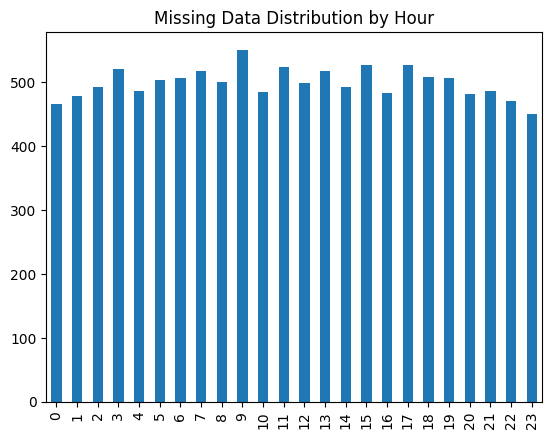

In [43]:
# Count how many times each HOUR of the day is missing
missing_hours_distribution = missing_dates.hour.value_counts().sort_index()
print("Distribution of missing data by hour of the day (0-23):")
print(missing_hours_distribution)

# You might want to plot this to see it better
import matplotlib.pyplot as plt
missing_hours_distribution.plot(kind='bar', title='Missing Data Distribution by Hour')
plt.show()

There is no patterns in missing values by hour

#### Check for patterns by the day of the week

In [44]:
# Count how many times each DAY OF THE WEEK is missing
# (0 = Monday, 6 = Sunday)
missing_dayofweek_distribution = missing_dates.dayofweek.value_counts().sort_index()
print("\nDistribution of missing data by day of the week (0=Mon, 6=Sun):")
print(missing_dayofweek_distribution)


Distribution of missing data by day of the week (0=Mon, 6=Sun):
0    1689
1    1800
2    1709
3    1715
4    1635
5    1728
6    1700
Name: count, dtype: int64


There is no patterns of missing values by the day of the week

#### Check for patterns by year


Distribution of missing data by Year-Month:
Year  Month
2012  10        44
      11        14
      12        14
2013  1        139
      2         78
              ... 
2018  1          2
      3         11
      5          1
      6          1
      8          4
Length: 63, dtype: int64


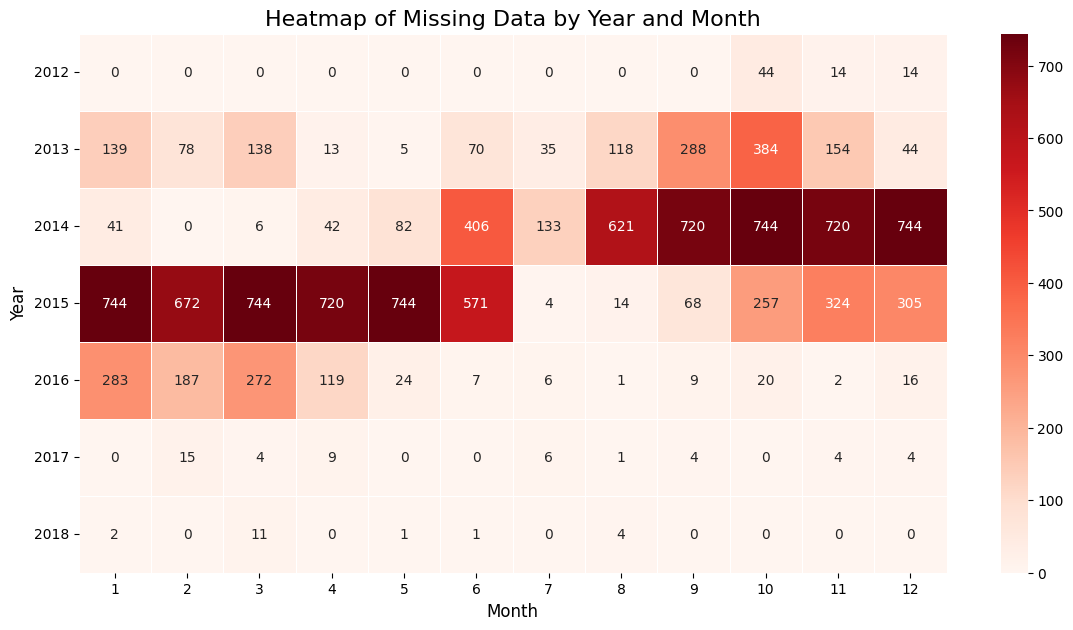

In [45]:
# Convert the DatetimeIndex to a Series to use .groupby()
missing_series = missing_dates.to_series()

# Group by both the year and the month of the index, then count the size of each group
missing_year_month_distribution = missing_series.groupby(
    [missing_series.index.year, missing_series.index.month]
).count()

# Rename the axes for clarity
missing_year_month_distribution.index.names = ['Year', 'Month']

print("\nDistribution of missing data by Year-Month:")
print(missing_year_month_distribution)

import matplotlib.pyplot as plt
import seaborn as sns

# Your data from the previous step (assuming it's named 'missing_year_month_distribution')
# missing_year_month_distribution = ...

# --- Plotting Code ---

# 1. Reshape the data for the heatmap
# We need to "unstack" the MultiIndex. We'll put 'Month' on the columns.
# .fillna(0) is important, as it fills in months that had 0 missing values.
try:
    data_heatmap = missing_year_month_distribution.unstack(level='Month').fillna(0)
    
    # 2. Create the plot
    plt.figure(figsize=(14, 7)) # Make the figure wider to fit 12 months
    
    # 3. Draw the heatmap
    sns.heatmap(
        data_heatmap, 
        annot=True,     # Show the numbers in each cell
        fmt=".0f",      # Format the numbers as integers (no decimals)
        cmap='Reds',    # Use a color scale from light to dark red
        linewidths=.5     # Add thin lines between cells
    )
    
    plt.title('Heatmap of Missing Data by Year and Month', fontsize=16)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Year', fontsize=12)
    plt.yticks(rotation=0) # Ensure Y-axis (Year) labels are horizontal
    
    plt.show()
    plt.close()

except Exception as e:
    print(f"An error occurred while creating the heatmap: {e}")
    print("This can happen if 'missing_year_month_distribution' is empty.")


So it is evident that the period 08/2014 - 06/2015 has several missing timestamps.

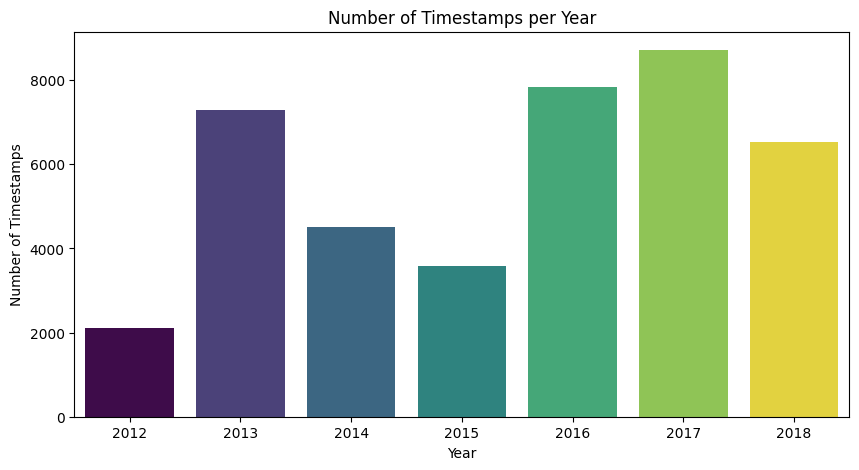

In [46]:
# analysing distribution of number of timestamps by year
timestamps_per_year = df.index.year.value_counts().sort_index()

# plotting the distribution
plt.figure(figsize=(10, 5))
sns.barplot(x=timestamps_per_year.index, y=timestamps_per_year.values, hue=timestamps_per_year.index, palette='viridis', legend=False)
plt.title('Number of Timestamps per Year')
plt.xlabel('Year')
plt.ylabel('Number of Timestamps')
plt.show()


### Removing the gap of missing timestamps

In [47]:
# Define the problematic period (adjust the exact dates based on your heatmap)
start_gap = '2014-08-01'
end_gap = '2015-07-01'

# Keep only the data OUTSIDE this period
df_cleaned = df.loc[(df.index < start_gap) | (df.index > end_gap)].copy()

# Use df_cleaned for the next steps
print(f"Lines before the remove: {len(df)}, Lines after remove: {len(df_cleaned)}")
print(f"Removed lines: {len(df) - len(df_cleaned)}")

Lines before the remove: 40575, Lines after remove: 40302
Removed lines: 273


### Treating the holiday coluumn

In [48]:
# Cleaning the 'holiday' column by filling NaN values with 'None'
df_cleaned['holiday'] = df_cleaned['holiday'].fillna('None')
print(df_cleaned['holiday'].value_counts())

holiday
None                         40249
Columbus Day                     5
Veterans Day                     5
Thanksgiving Day                 5
Christmas Day                    5
New Years Day                    5
Washingtons Birthday             5
Memorial Day                     5
Independence Day                 5
State Fair                       5
Labor Day                        5
Martin Luther King Jr Day        3
Name: count, dtype: int64
